# Stock Market Volatility and Earnings Dates

Team Members:
- Colin Jennings
- Anish Machiraju
- Alec Borer
- Charles Heese

### Introduction and Questions:
Are risk and return correlated? According to classic financial theory such as the risk-return tradeoff and Capital Asset Pricing Model (CAPM), the market, on average, rewards investors who take on more risk by offering them higher profits. 

If this was a good investment strategy, everyone would simply look at volatility. However, in markets where information and trading moves faster than ever, these assumptions hold less and less true. This brings us to a guiding question: what if we look at expectation instead of just information? For instance, will the market act rationally if an earnings report is coming up soon? We formally pose two questions:

1) The first question is such: if volatile assets have the potential for high returns, are these gains offset by larger losses?

2) Is the volatility affected by how close the earnings reports are?


### The Data Pipeline:
1) Get stock high, low, close, volume (numeric)
2) Calculate RSI, volatility, returns
3) Get earnings report dates, ESP values
4) Visualize data, use machine learning methods.
5) Noramlize individual stocks to entire stock market (if necessary)
 
We want lots of time-series graphs for stocks, but we will collect two types of data. Numeric data consists of the opening price, closing price, and volume of the stock. We interpret this over a moving window to get volatility as well as the RSI. Earnings reports are something else to consider, so we pull them with the AlphaVantage API and syncronize them with price data. From here, we can look at the number of days to an earnings report and compare that to volatility. We also look at the EPS to see if it goes up or down from the last report, thus giving us more data from which to form our model.

### Part 2: Obtain, clean, merge data

In [4]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import requests
from io import StringIO
import time
from tqdm import tqdm 
import numpy as np
# scrape the S&P 500 from wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

response = requests.get(wiki_url)

# wrap the text in StringIO object to prevent Pandas "future warning"
wiki_tables = pd.read_html(StringIO(response.text))

# the first table is the relevant one
sp500_table = wiki_tables[0]

# there are actually 503 companies in the s&p 500
sp500_table.shape

(503, 8)

In [5]:
# notice we also gets the sector and sub-industry
sp500_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [6]:
# get the stock tickers
ticker_list = sp500_table["Symbol"].tolist()

# replace the dots with dashes to be compatible with yahoo finance api
ticker_list = [ticker.replace(".","-") for ticker in ticker_list]

# For testing, only use 50 tickers:
ticker_list = ticker_list[:50]

# look at a 5 year window
start_date = "2020-01-01"
end_date = "2025-01-01"


def get_stock_data(ticker, start_date=start_date, end_date=end_date):
    """ Gets the historic data for a stock based on the ticker and a date range.
    
    Args:
        ticker (str): The stock ticker
    Returns:
        stock (Pandas DataFrame): time-series historical data for a stock
    """

    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    
    # remove the ticker column -- the ticker will be found in the filename
    temp_df.columns = temp_df.columns.droplevel(1)
    
    return temp_df


# list of dataframes, each being stock data
all_stock_data = []

# we use tqdm to create a useful progress bar
for ticker in tqdm(ticker_list, desc="Downloading stocks..."):
    
    temp_df = get_stock_data(ticker)

    # check if empty or full of NaN (happens when spamming api)
    if temp_df.empty or temp_df.isna().all().all():
        print(f"Error getting {ticker}")
    else:
         all_stock_data.append(temp_df)

    # prevents too many api calls
    time.sleep(1)


print(f"Collected {len(all_stock_data)} stocks")



Collected 50 stocks


In [7]:
# we compute the RSI and add it as a column

def compute_rsi(series, window=14):
    """ Computes the Relative Strength Index of a series. Formulas and conventions found here [3].

    Args:
        series (Pandas.series): The stock data
        window (int): The number of feadings to look over (convention is usually 14 days)
    Returns:
        rsi (Pandas.series): The RSI series corresponding to the data
    """
    
    # gets the difference between values
    diff_series = series.diff()

    # create two series, the gains days of increase, the losses are days of decrease
    gains = diff_series.apply(lambda x: x if x > 0 else 0)
    losses = diff_series.apply(lambda x: -x if x < 0 else 0)

    # measure the average gain and loss of a 14 day sliding window
    avg_gain = gains.rolling(window=window, min_periods=window).mean()
    avg_loss = losses.rolling(window=window, min_periods=window).mean()

    # get relative strength (average gain divided by average loss) then get the index
    rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def classify_rsi(rsi):
    """ Classifies an RSI value into one of three categories.
    
    Args:
        rsi (int): the rsi
    Returns:
        RSI_class (str): the categorical indicator
    """

    if np.isnan(rsi):
        return np.nan
    if rsi > 70:
        return "Overbought"
    elif rsi < 30:
        return "Oversold"
    else:
        return "Neutral"


# compute the rsi and rsi class of all stocks
for stock_data, ticker in zip(all_stock_data, ticker_list):

    # get the rsi of the closing data for all stocks
    stock_data['RSI'] = compute_rsi(stock_data['Close'])

    # add the rsi class
    stock_data['RSI_class'] = stock_data['RSI'].apply(classify_rsi)

    # locally save the stock data so we can read it easier
    # stock_data.to_csv(f"stock_data/{ticker}.csv")
    

# example for $MMM -- notice that the RSI only starts on day 14, as it is a moving measure
print("Example data for " + ticker_list[0])
all_stock_data[0].head(20)

Example data for MMM


Price,Close,High,Low,Open,Volume,RSI,RSI_class
Date,,,,,,,
2020-01-02,122.357460,122.364258,120.413330,120.780405,4307633,NaN,NaN
2020-01-03,121.303772,121.446520,119.386835,120.331714,2950412,NaN,NaN
2020-01-06,121.419365,121.480548,119.876300,120.420114,2389608,NaN,NaN
2020-01-07,120.929909,121.344570,120.195760,121.188213,2598908,NaN,NaN
2020-01-08,122.785660,123.377060,120.759965,120.997888,3298927,NaN,NaN
2020-01-09,123.173141,123.438244,122.194285,123.383871,3284575,NaN,NaN
2020-01-10,122.676949,123.839343,122.452623,123.451874,2516145,NaN,NaN
2020-01-13,122.982811,123.873304,122.602140,122.996407,2500597,NaN,NaN
2020-01-14,123.288689,124.090806,122.500167,122.982798,3481795,NaN,NaN


In [8]:
# Lets implement logarithimc returns as a columnn. 

def compute_log_return(series):
    """ Computes the logarithmic return of a series. The logarithmic return is simply the natural
    logarithm of the closing price yesterday divided by the closing price today.

    Args:
        series (Pandas.series): series of closing prices
    Returns:
        log_returns (Pandas.series): series of returns
    """

    # offset the days by 1
    day_offset = series.shift(1)
    
    return  np.log(series / day_offset)


def compute_volatility(series, window=14):
    """ Computes the volatilty of a logarithmic return series with a given window.

    Args:
        series (Pandas.series): The logarithmic return data
        window (int): The number of readings to look over (14 days, the same as RSI)
    Returns:
        rsi (Pandas.series): The logarithmic return series
    """

    # use the exact same approach as with RSI, but with standard deviation
    volatility = series.rolling(window=window, min_periods=window).std()

    return volatility


# compute the log returns and log return class of all stocks
for stock_data, ticker in zip(all_stock_data, ticker_list):

    
    stock_data['Log_return'] = compute_log_return(stock_data['Close'])

    stock_data['Volatility'] = compute_volatility(stock_data['Log_return'])

# example for $MMM -- 
# notice that the Log_Return only starts on day 2, so volatility starts on day 15 -- to be expected
# 
print("Example data for " + ticker_list[0])
all_stock_data[0].head(20)


Example data for MMM


Price,Close,High,Low,Open,Volume,RSI,RSI_class,Log_return,Volatility
Date,,,,,,,,,
2020-01-02,122.357460,122.364258,120.413330,120.780405,4307633,NaN,NaN,NaN,NaN
2020-01-03,121.303772,121.446520,119.386835,120.331714,2950412,NaN,NaN,-0.008649,NaN
2020-01-06,121.419365,121.480548,119.876300,120.420114,2389608,NaN,NaN,0.000952,NaN
2020-01-07,120.929909,121.344570,120.195760,121.188213,2598908,NaN,NaN,-0.004039,NaN
2020-01-08,122.785660,123.377060,120.759965,120.997888,3298927,NaN,NaN,0.015229,NaN
2020-01-09,123.173141,123.438244,122.194285,123.383871,3284575,NaN,NaN,0.003151,NaN
2020-01-10,122.676949,123.839343,122.452623,123.451874,2516145,NaN,NaN,-0.004037,NaN
2020-01-13,122.982811,123.873304,122.602140,122.996407,2500597,NaN,NaN,0.002490,NaN
2020-01-14,123.288689,124.090806,122.500167,122.982798,3481795,NaN,NaN,0.002484,NaN


### Another component:

Earnings reports are very important when thinking about volatility. 

I will days to earnings report with the alpha vantage API, as well as the EPS (earnings per share) on the date.

I hypothesize that as a stock nears its earning date, volatility increases, but I cannot say for sure.

In [10]:
import requests

# example of alpha
API_KEY = "GDEK4PY7POOU14P5" 
ticker = "AAPL"

url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={API_KEY}"
response = requests.get(url)
data = response.json()

# example of historical earnings dates for apple
earnings_history = data.get("quarterlyEarnings", [])

# for each report, there is a date and and EPS. We will be using 'reportedDate' and 'reportedEPS'
print([report for report in earnings_history[:5]])

[{'fiscalDateEnding': '2024-12-31', 'reportedDate': '2025-01-30', 'reportedEPS': '2.4', 'estimatedEPS': '2.36', 'surprise': '0.04', 'surprisePercentage': '1.6949', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2024-09-30', 'reportedDate': '2024-10-31', 'reportedEPS': '1.64', 'estimatedEPS': '1.6', 'surprise': '0.04', 'surprisePercentage': '2.5', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2024-06-30', 'reportedDate': '2024-08-01', 'reportedEPS': '1.4', 'estimatedEPS': '1.35', 'surprise': '0.05', 'surprisePercentage': '3.7037', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2024-03-31', 'reportedDate': '2024-05-02', 'reportedEPS': '1.53', 'estimatedEPS': '1.5', 'surprise': '0.03', 'surprisePercentage': '2', 'reportTime': 'post-market'}, {'fiscalDateEnding': '2023-12-31', 'reportedDate': '2024-02-01', 'reportedEPS': '2.18', 'estimatedEPS': '2.1', 'surprise': '0.08', 'surprisePercentage': '3.8095', 'reportTime': 'post-market'}]


In [11]:

def get_earnings_data(ticker):
    """ Gets a dataframe with earnings information from AlphaVantage.

    Args:
        ticker (str): the stock ticker

    Returns:
        earnings_df (Pandas.DataFrame): the dataframe with earnings information
    """

    # get the data, return nothing if empty
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    
    if "quarterlyEarnings" not in data:
        return None

    # convert the date to a datetime and the EPS to a float
    earnings_df = pd.DataFrame(data['quarterlyEarnings'])
    earnings_df['reportedDate'] = pd.to_datetime(earnings_df['reportedDate'])
    earnings_df['reportedEPS'] = pd.to_numeric(earnings_df['reportedEPS'])
    
    return earnings_df


def add_earnings_info(stock_df, earnings_df):
    """ Adds the earnings dataframe to the existing stock dataframe with respect to date.

    Args:
        stock_df (Pandas.DataFrame): the dataframe with stock information
        earnings_df (Pandas.DataFrame): the dataframe with earnings information

    Returns:
        nothing
    """

    # check if earnings df is empty
    if earnings_df is None:
        print("Error: Earnings data is None. Please check the data retrieval process.")
        return None

    # create columns, fill with NaN
    stock_df['Days_to_Earnings'] = np.nan
    stock_df['Last_EPS'] = np.nan

    # ensure earnings_df is sorted, then get it as a list
    earnings_dates = earnings_df['reportedDate'].sort_values().tolist()

    # iterate through rows -- current_date is the index
    for current_date, row in stock_df.iterrows():

        # create sublists of dates that are ahead and behind the current date
        future_earnings = [date for date in earnings_dates if date >= current_date]
        past_earnings = [date for date in earnings_dates if date < current_date]

        # check if there are future earnings
        if future_earnings:
            
            # get the next earning date, then compare the dates and get the number of days in between
            next_earnings_date = future_earnings[0]

            # subtracting datetime from datetime gives a timedelta object, then we get .days property
            days_to_earnings = (next_earnings_date - current_date).days
            stock_df.at[current_date, 'Days_to_Earnings'] = days_to_earnings
        
        # check if there are past earnings
        if past_earnings:

            # row where date matches most recent past earning date
            last_earnings_row = earnings_df.loc[earnings_df['reportedDate'] == past_earnings[-1]]

            # get the first value in this series
            last_eps = last_earnings_row['reportedEPS'].values[0]
            
            stock_df.at[current_date, 'Last_EPS'] = last_eps


# example -- printing stock data for MMM, we can see that when Days_to_earnings resets, Last_EPS changes
add_earnings_info(all_stock_data[0],get_earnings_data(ticker_list[0]))
all_stock_data[0][10:25]

Price,Close,High,Low,Open,Volume,RSI,RSI_class,Log_return,Volatility,Days_to_Earnings,Last_EPS
Date,,,,,,,,,,,
2020-01-16,123.043961,123.173113,122.146669,122.819635,2571280,NaN,NaN,0.006818,NaN,12.0,2.58
2020-01-17,123.275078,123.818891,122.833237,123.037168,4413360,NaN,NaN,0.001877,NaN,11.0,2.58
2020-01-21,121.942795,123.655801,121.426174,123.615012,4027769,NaN,NaN,-0.010866,NaN,7.0,2.58
2020-01-22,121.018303,122.744905,120.916343,122.024365,2894559,42.887948,Neutral,-0.007610,NaN,6.0,2.58
2020-01-23,120.821159,121.296991,119.903474,120.365709,2820646,42.008296,Neutral,-0.001630,0.007111,5.0,2.58
2020-01-24,121.099892,122.228295,120.678445,121.331016,3161148,48.846425,Neutral,0.002304,0.006788,4.0,2.58
2020-01-27,119.386871,122.758497,119.325688,122.262271,5216234,40.260535,Neutral,-0.014247,0.007751,1.0,2.58
2020-01-28,112.555252,117.150456,112.194988,116.851363,10669157,25.040486,Oversold,-0.058925,0.017297,0.0,2.58
2020-01-29,110.121704,113.160247,109.802217,113.078669,6391304,13.513448,Oversold,-0.021858,0.016771,90.0,2.15


In [12]:

# run this for every company, using tqdm to track progress
for stock_data, ticker in tqdm(zip(all_stock_data, ticker_list), total=len(all_stock_data)):
    add_earnings_info(stock_data, get_earnings_data(ticker))
    time.sleep(1)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:29<00:00,  5.39s/it]


In [13]:
# test with last stock
print(f"Data for {ticker_list[49]}:")
all_stock_data[49]


Data for ADSK:


Price,Close,High,Low,Open,Volume,RSI,RSI_class,Log_return,Volatility,Days_to_Earnings,Last_EPS
Date,,,,,,,,,,,
2020-01-02,187.830002,187.889999,181.880005,184.210007,1515000,NaN,NaN,NaN,NaN,56.0,0.78
2020-01-03,184.949997,186.410004,183.779999,184.490005,737900,NaN,NaN,-0.015452,NaN,55.0,0.78
2020-01-06,187.119995,187.250000,183.160004,183.779999,1021900,NaN,NaN,0.011665,NaN,52.0,0.78
2020-01-07,187.500000,188.169998,185.100006,186.130005,897200,NaN,NaN,0.002029,NaN,51.0,0.78
2020-01-08,189.949997,190.500000,187.029999,188.220001,1314800,NaN,NaN,0.012982,NaN,50.0,0.78
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,301.230011,301.230011,296.679993,297.549988,560000,46.482183,Neutral,0.012494,0.013531,64.0,2.17
2024-12-26,300.279999,301.730011,299.429993,299.429993,646800,44.267286,Neutral,-0.003159,0.013499,62.0,2.17
2024-12-27,297.589996,298.839996,294.570007,298.640015,1041600,38.177606,Neutral,-0.008999,0.013359,61.0,2.17


### Part III: Visualizations:
I will plot days to earnings with logarithmic volatility for an arbitrary stock. The final project will involve aggregating the findings from all stocks, but this is a good place to start.

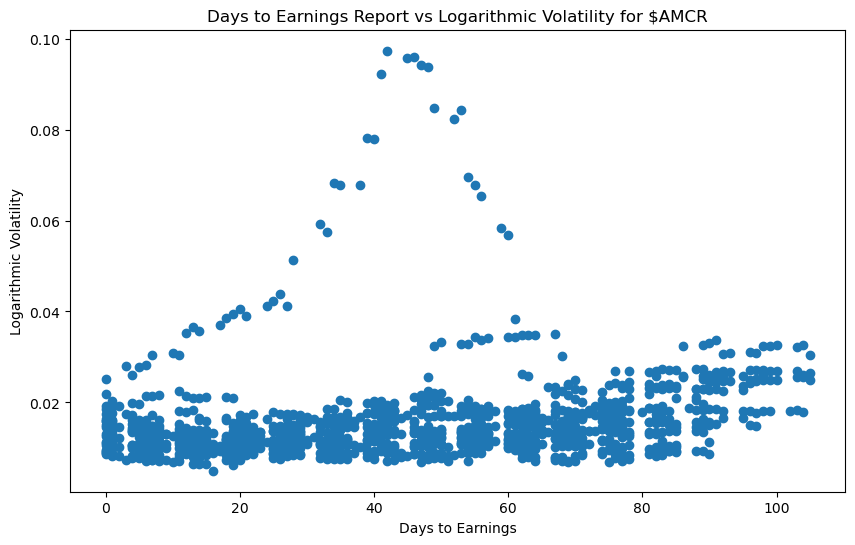

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# plot for an arbitrary stock
stock_data = all_stock_data[23]

plt.figure(figsize=(10, 6))

# Ensure Days_to_Earnings and Volatility are properly numeric lists/arrays
plt.scatter(stock_data['Days_to_Earnings'],stock_data['Volatility'])
plt.title(f"Days to Earnings Report vs Logarithmic Volatility for ${ticker_list[23]}")
plt.xlabel('Days to Earnings')
plt.ylabel('Logarithmic Volatility')
plt.show()


This is a plot in support of question number 2. I notice that there seems to be a slight positive correlation as you get to higher values -- although the data is more sparse, when there is more time to the next earnings report, there is more volatility. This could be because the value for EPS was much different than expeected, causing either a big sell or big buy.

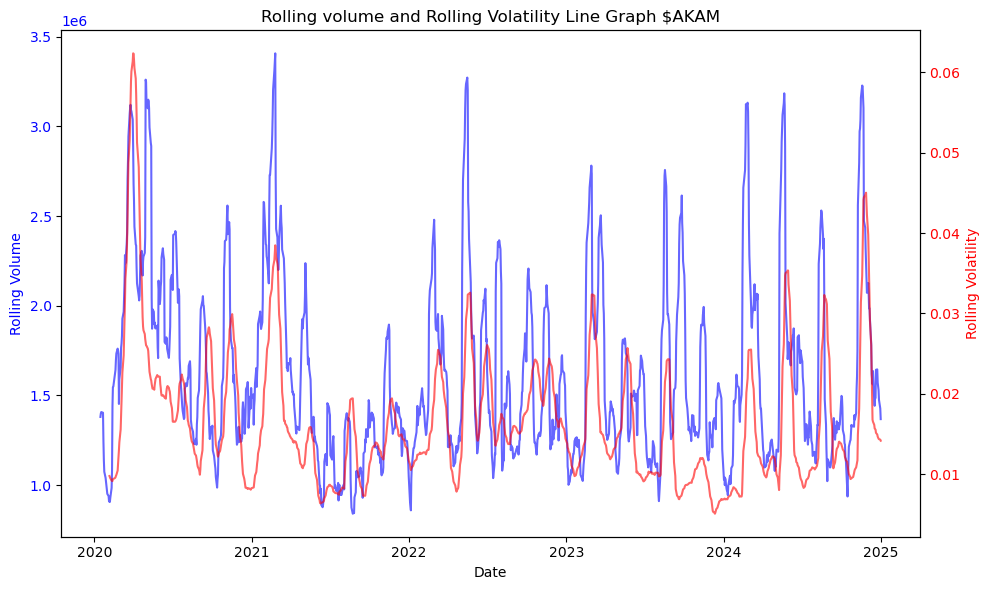

In [17]:

# lets again go with an example plot for a
stock_data = all_stock_data[12]

# get rolling volume and volatility
rolling_volume= stock_data['Volume'].rolling(window=10).mean()
rolling_volatility = stock_data['Volatility'].rolling(window=10).mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

# plot the rolling volume in blue
ax1.plot(stock_data.index, rolling_volume, color='blue',  alpha=0.6)
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Volume', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# plot the rolling volatility in red
ax2 = ax1.twinx()
ax2.plot(stock_data.index, rolling_volatility, color='red', alpha=0.6)
ax2.set_ylabel('Rolling Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f"Rolling volume and Rolling Volatility Line Graph ${ticker_list[12]}")
fig.tight_layout()
plt.show()


Although the relationship between volume and volatility can be quite complex, there are some interesting takeaways from this graph. To start, it seems that volatility and volume peaks coincide. Intuitively, this makes sense -- if a stock starts to fluctuate, more people will trade it. This creates a vicious cycle until it evens back out again.

Another thing it illustrates is how much volume changes day-to-day. For this stock, it is fluctuating between 1 million and 3 million shares sold. That is quite a difference, so I think it shows the need for a machine learning model that can infer more complex relationships than human eyes alone can.

ML Model Coefficients:
[ 3.00625278e-04  2.92966710e+00 -1.95393527e+00 -1.58303741e-01
  1.66187344e-01  1.27486205e-10 -1.52404357e-10  2.62736540e-11]
R²: 0.9962
MSE: 0.000001
rolling_vol_lag1: 2.929667
rolling_vol_lag2: -1.953935
rolling_vol_lag3: -0.158304
rolling_vol_lag4: 0.166187
rolling_volume: 0.000000
rolling_volume_lag1: -0.000000
rolling_volume_lag2: 0.000000
Intercept: 0.000301


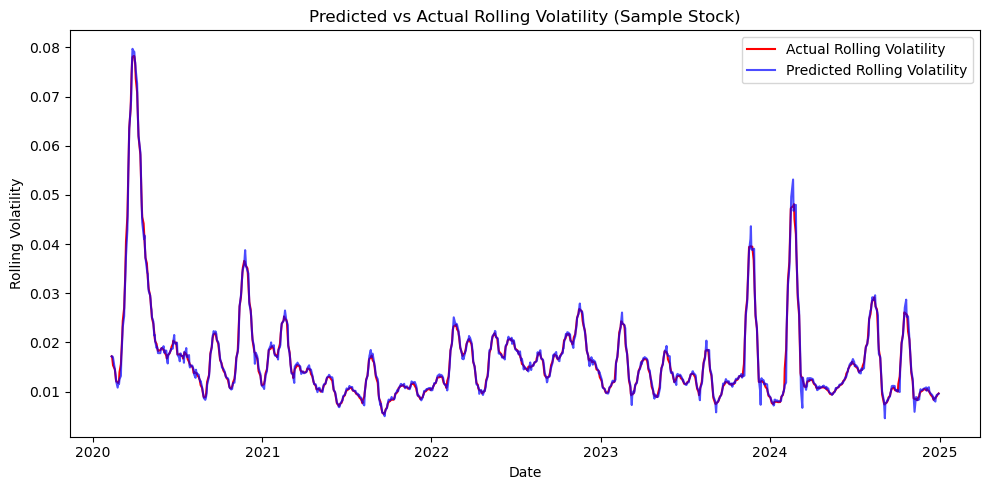

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create feature matrix for all stocks 
feature_list = []

for stock_data in all_stock_data:
    # copy original df (stock_data) into df
    df = stock_data.copy()
    
    # Rolling mean of volatility
    df['rolling_vol'] = df['Volatility'].rolling(window=10).mean()

    # create a shifted target (i.e. 1 day ahead prediction for rolling volatility)
    df['rolling_vol_shifted'] = df['rolling_vol'].shift(-1)  

    # create lagged features (past 4 days) for historical training and comparison
    df['rolling_vol_lag1'] = df['rolling_vol'].shift(1)
    df['rolling_vol_lag2'] = df['rolling_vol'].shift(2)
    df['rolling_vol_lag3'] = df['rolling_vol'].shift(3)
    df['rolling_vol_lag4'] = df['rolling_vol'].shift(4)

    # calc rolling mean of volume and 2 lagged features 
    df['rolling_volume'] = df['Volume'].rolling(window=10).mean()
    df['rolling_volume_lag1'] = df['rolling_volume'].shift(1)
    df['rolling_volume_lag2'] = df['rolling_volume'].shift(2)

    # drop any rows that have NaNs that were created by the shifts 
    df = df.dropna().copy()
    feature_list.append(df)

# combine all the stocks into a single dataset
ml_df = pd.concat(feature_list, ignore_index=True)

# create X axis df (feature matrix / independent variable which is the rolling volume)
X_ml = ml_df[['rolling_vol_lag1', 'rolling_vol_lag2', 'rolling_vol_lag3', 'rolling_vol_lag4',
              'rolling_volume', 'rolling_volume_lag1', 'rolling_volume_lag2']].values

# create y axis df (dependent variable = future volatility)
y_ml = ml_df['rolling_vol_shifted'].values

# add a col of 1s to include the intercept term in the regression model 
X_design = np.hstack((np.ones((X_ml.shape[0], 1)), X_ml))  # Add bias column

# fit the model using closed form OLS solution (i.e. (X^T x X)^-1 x X^T x y)
theta_ml = np.linalg.inv(X_design.T @ X_design) @ (X_design.T @ y_ml)

# model's predicted rolling volatility
y_pred_ml = X_design @ theta_ml

# difference between actual and predicted values
residuals_ml = y_ml - y_pred_ml

# evaluate model 
ss_total = np.sum((y_ml - np.mean(y_ml))**2)
ss_res = np.sum((residuals_ml)**2)
r2_ml = 1 - ss_res / ss_total
mse_ml = np.mean(residuals_ml**2)

print(f"ML Model Coefficients:\n{theta_ml}")
print(f"R²: {r2_ml:.4f}")
print(f"MSE: {mse_ml:.6f}")

intercept = theta_ml[0]
coef_names = [
    'rolling_vol_lag1', 
    'rolling_vol_lag2', 
    'rolling_vol_lag3', 
    'rolling_vol_lag4',
    'rolling_volume', 
    'rolling_volume_lag1', 
    'rolling_volume_lag2'
]

for i, name in enumerate(coef_names):
    print(f"{name}: {theta_ml[i+1]:.6f}")

print(f"Intercept: {intercept:.6f}")

# choose a stock and test the model on it for visualization
sample_df = feature_list[10] 

# create sample x using data from 10th stock 
sample_X = sample_df[['rolling_vol_lag1', 'rolling_vol_lag2', 'rolling_vol_lag3', 'rolling_vol_lag4',
                      'rolling_volume', 'rolling_volume_lag1', 'rolling_volume_lag2']].values

# apply the machine learning algo and compare to the actual values 
sample_X_design = np.hstack((np.ones((sample_X.shape[0], 1)), sample_X))
sample_y_pred = sample_X_design @ theta_ml
sample_y_actual = sample_df['rolling_vol_shifted'].values

# plot to demonstrate the actual vs predicted values of rolling volatility 
plt.figure(figsize=(10, 5))
plt.plot(sample_df.index, sample_y_actual, label='Actual Rolling Volatility', color='red')
plt.plot(sample_df.index, sample_y_pred, label='Predicted Rolling Volatility', color='blue', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rolling Volatility")
plt.title("Predicted vs Actual Rolling Volatility (Sample Stock)")
plt.legend()
plt.tight_layout()
plt.show()


Based on our ML model this is the predicted volatility formula

volatility = 0.000301+(2.9297⋅Lag1_Vol)+(−1.9539⋅Lag2_Vol)+(−0.1583⋅Lag3_Vol)+(0.1662⋅Lag4_Vol)+(0⋅Volume)+(0⋅Volume_Lag1)+(0⋅Volume_Lag2)

Interesting notes: 
- Volume adds essentially no value (i.e. the coefficients are so close to zero that it is negligible)
- The model is essentially saying "If volatility was high yesterdat, it's likely to be high tomorrow, but watch out for reversals or patterns from 2-4 days ago
- I tested around 50% of the graphs to see how accurate the predicted vs actual were and most of them almost perfectly align (there seem to exceptions at many of the large peaks, not sure how to improve on this though - we could add more lags perchance)


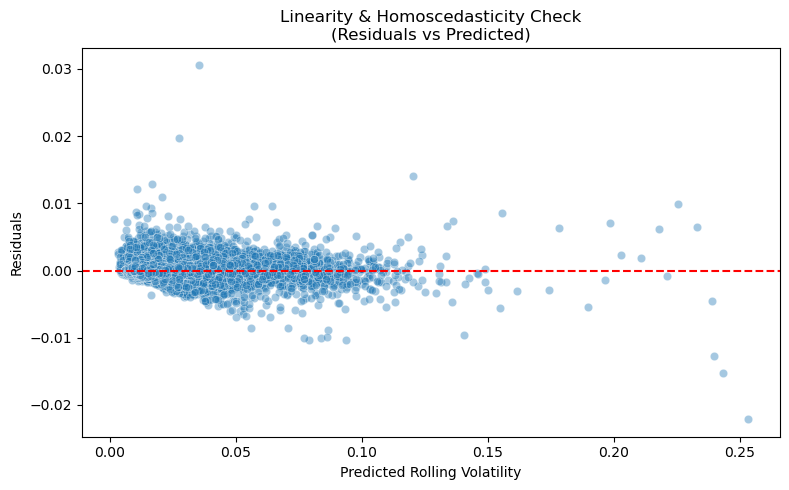

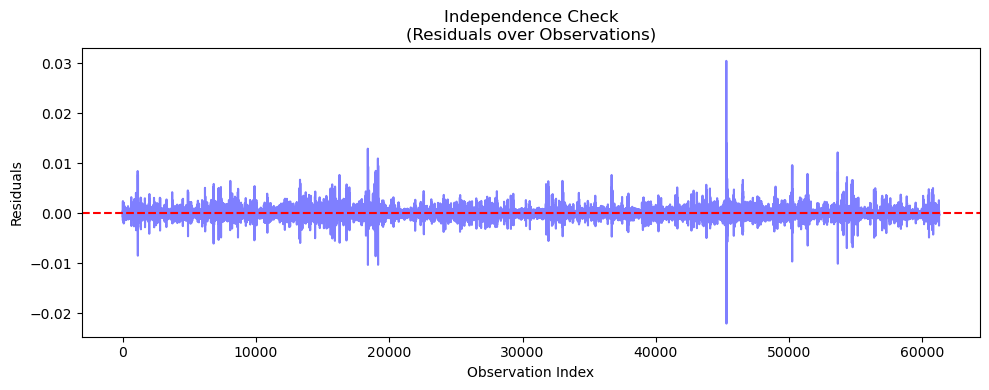

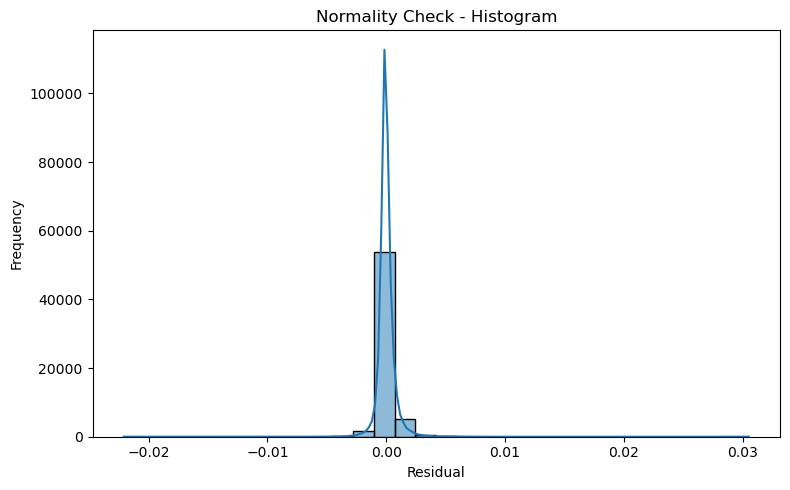

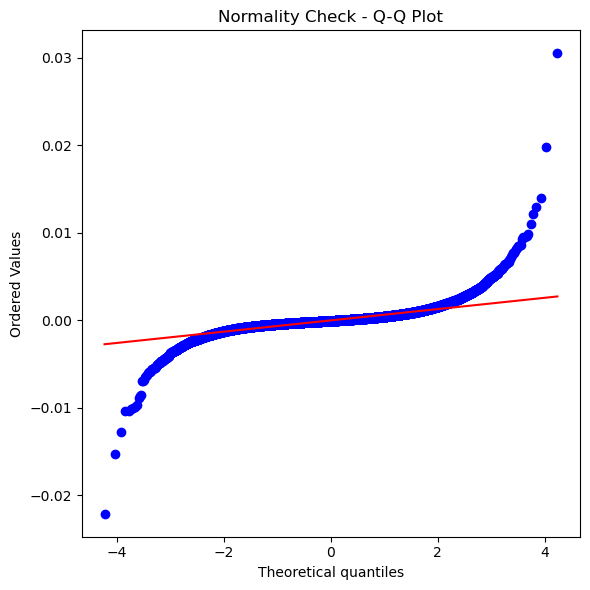

In [61]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# linearity and homoscedasticity
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_ml, y=residuals_ml, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Rolling Volatility")
plt.ylabel("Residuals")
plt.title("Linearity & Homoscedasticity Check\n(Residuals vs Predicted)")
plt.tight_layout()
plt.show()

# indepedence
plt.figure(figsize=(10, 4))
plt.plot(residuals_ml, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.title("Independence Check\n(Residuals over Observations)")
plt.tight_layout()
plt.show()

# normality - histogram
plt.figure(figsize=(8, 5))
sns.histplot(residuals_ml, bins=30, kde=True, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Normality Check - Histogram")
plt.tight_layout()
plt.show()

# normality - Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals_ml, dist="norm", plot=plt)
plt.title("Normality Check - Q-Q Plot")
plt.tight_layout()
plt.show()


1. Linearity And Homoscedastcity
   - Residuals are centered around zero across the range of predicted values (good for linearity)
   - More spread in the residulas when the predictions are small and tightens as it grows
   - __Linearity seems to hold, but homoscedeasticity may be slightly violated__
2. Independence
   - No visible trend, wave patterns, or systematic clustering
   - A few spkikes but they are not repeating regularly or persisting
   - __Independence is satisfied and no autocorrelation is apparent in the residuals__
3. Normality - Histogram
   - Very narrow and tall bell shape around zero
   - Slight positive skew
   - Still resembles a Gaussian distribution closely
   - __It is mostly normal, but the residuals may be a little too concentrated, but given how large the dataset is, I think its acceptable__
4. Normality - Q-Q Plot
   - Most residuals are close to the line but there is a clear S-curve patterns (suggests deviation from perfect normality)
   - Heavy tails so more extreme values than expected
   - __Normality is violted slightly especially in the tails, since the goal is prediction it shouldn't be a major issue__

Things to get done before the deadline: 
- discuss some potential ethical considerations of project
- more of a discussion of preliminary results (I did a lot but i think we need more)
- ^^^ Can include more discussion of assumptions, more plots/tables, measures of fit, or other attributes of analysis
- 